# What is the reason for medical missed appointment. 

## Introduction

Medical appointments are a way medical facilities follow up on patient's treatments for certain medical conditions. When such appointments are scheduled, the time of all medical staffs involved are put into it, and other appointments are suspended because of the scheduled appointment. Now when such scheduled appointments are missed and at a high rate, it puts cost on the clinic in terms of wasted hours for the doctor and staff. 

Our goal in this project coordinated by Udacity team in the nanodegree data analyst program is to identify some of these reasons why patients miss an appoitment. We will investigate a dataset of over 100,000 medical appointments in Brazil with focus on the question of whether or not patients attend their appointments. A number of characteristics about the patient are included in the dataset.

The following reasons are likely to contribute:
 

 1) Cost:
When patients do not have medical aids or insurance, they are likely to miss an appointment especially when they feel healthy and strong. To account for cost, in our data set, we have information about scholarships, we will assume this means medical insuranceand.
 
 2) Fear
Patients who had medical conditions such as alcohol, or hypertention might not want to be lectured about their unhealthy behaviors such as drinking or not following medical advice, thus may dread to keep up with appointments.

 3) Time
It is easy to miss an appointment which is scheduled to take place in weeks or months in advance. Sometimes if it ends up falling on a particularly busy day, patients may call to reschedule the appointments or may forget about the appointment. It is always necessary to send a reminder to patients following up their appointment date

 4) Demographics
When we look at factors such as age, special needs, home address, one could conclude that patients who are elderly or with special needs may have challenges transporting themselves to the hospital, particularly during inclement weather. 

 5) Others
Other factors such as management of patients with critical diseases or preventive screening may allow patients to turn up to other healthcare faicilities with more serious and more costly health concerns.



### Note

This project does not provide final conclusions on why patients miss appointments as algorithms from Machine learning or inferential statistical techniques were not employed. The project will be revisited as we progress in the course to utilize more advanced data analysis techniques/algorithms.

We will answer certain research questions in the process of the analysis.






In [394]:
#importing useful packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


%matplotlib inline

In [395]:
#load data

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

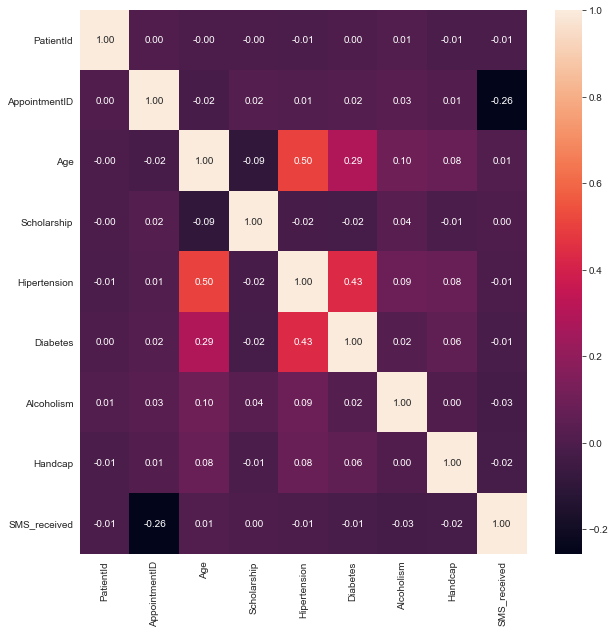

In [396]:
#let us take a look at correlations in our data

plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True,fmt=".2f");

### Observations

- The chart above shows that the column with the strongest correlation with Age is Hypertention, then Diabetes. Also, we find a correlation between Hypertension and Diabetes. Thus we will focus our statistical analysis on these columns. 

- The strongest negative relationship (which is between AppointmentID column and SMS_recieved) had 0.26 correlation value.

- There are no mising data in the columns. 

# Data Wrangling

In this section, we will process and clean our data. 

## 2.1. Summary of dataset
Let us take a look at information about the data

In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Observations
- As we already discussed, there are no missing data in the columns
- The number of rows and columns are 110527 and 14 respectively
- Certain columns such as appointment wait times and appointment day of week, that I think will be useful for the statistical analysis are misisng and will be created.
- There are problems with the data such as typos in the column names which we will clean up and inconsistent data types.

## 2.2. Updating Column names

### 2.2.1. Cleaning column labels

In [398]:
#view column
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [399]:
# Correct typos and rename 

df.columns = ['patient_id', 'appointment_id', 'gender', 'schedule_day', 'appointment_day', 'age',
              'neighbourhood','insurance','hypertension','diabetes','alcoholism'
              ,'handicap','appointment_reminder','appointment_adherence']

### 2.2.2.  Data type conversion 

We will convert the data in the following columns
- patient_id from float to integer
- appointment_day from string to datetime format
- schedule_day from string to datetime format

In [400]:
#Convert patient_id, appointment_day and schedule_day  data types 

df['patient_id'] = df['patient_id'].astype('int64') #float to integer
df['appointment_day'] = pd.to_datetime(df['appointment_day']).dt.date.astype('datetime64[ns]') #string to datetime
df['schedule_day'] = pd.to_datetime(df['schedule_day']).dt.date.astype('datetime64[ns]') #string to datetime
#df['Wait_Time'] = df['Wait_Time'].astype('timedelta64[D]').astype(int)



### 2.2.3 Create new columns
First column to create is the appoinment wait times which we calculate using the mathematical
#### wait_times = appointment_day - schedule_day
We expect wait_times > 0, that is appoinments are usually scheduled before attendance. Anything other than this will be considered an abnormality and will be fixed.

In [401]:
#create the wait_times column and covert data type to integer.
df['wait_times']=(df.appointment_day - df.schedule_day).astype('timedelta64[D]').astype(int)

# Print the number of wait_times column
df['wait_times'].describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: wait_times, dtype: float64

We that the minimum wait time for an appointment is -6, a negative value which is abnormal. This suggest that there are abnormalities in the appointment_day or schedule_day columns which we will fix later.

#### Day of week
Next column we see necessary is the appointment day of the week.

In [402]:
# Create a new column called day_of_week
df['day_of_week'] = df.schedule_day.dt.day_name()

# Print the number of appointments per day of week in descending order
df['day_of_week'].describe()

count      110527
unique          6
top       Tuesday
freq        26168
Name: day_of_week, dtype: object

The day with the highest number of appointment is Tuesday with about 26168 appointments. Also there are 6 unique days.To see these days and what number of appointments are booked on them.

In [403]:
df['day_of_week'].value_counts()

Tuesday      26168
Wednesday    24262
Monday       23085
Friday       18915
Thursday     18073
Saturday        24
Name: day_of_week, dtype: int64

Thus the next day of the week with highest appointments booked is Wednesday with a total of 24262 appointments. There are no appointments booked on Sundays and Saturday has the least appointment, 24 appointments.

## 2.3. Data processing / cleaning

In [404]:
df.describe() #a look at the statistics of the numerical part of our data

,patient_id,appointment_id,age,insurance,hypertension,diabetes,alcoholism,handicap,appointment_reminder,wait_times
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183702
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254996
min,3.921700e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


### Observations

- The average age of patient that booked an appointment is 37. The minimum and maximum ages are -1 and 115 respectively. These minimum and maximum are unrealistic, we can accept ages 0 for infants not upto a year old, and a maximum age of 100.

- A negative wait time would only suggest that some appointments were scheduled before the actual appointment day. This has to be cleaned up.

- We observe a category of data with bolean data types of 0 and 1 respectively. These include insurance, hypertension, diabetes, alcoholism, appointment_reminder, and (probably) the handicap columns respectively. However we observe a maximum of 4 in handicap column which would have to be investigated later.

- Handicap column has a maximum value of 4 and minimum of 0. This is unlike the other =-[]categorical variables with binary logic. We will set all fields greater than 1 to 1 with the assumption that you are either handicapped (1) or not (0).

In [405]:
df.describe(include=[np.object]) #a look at the statistics of colums with object data type

,gender,neighbourhood,appointment_adherence,day_of_week
count,110527,110527,110527,110527
unique,2,81,2,6
top,F,JARDIM CAMBURI,No,Tuesday
freq,71840,7717,88208,26168


### Observations

- The population with the highest number of booked appointment are females, making up a total of 71840 of total patients population.
- There are 81 unique neighbourhoods with JARDIM CANBURI being the most popular place patients who booked appointment live. We notice a total of 7717 appointments were scheduled for patients in the JARDIM neighbourhood. This column will be dropped as they are not useful for our analysis
- More appointments (about 88208 out of the total number of appointments) were attended than missed. 
- Appointments are scheduled more on Tuesdays with the frequency being 26168

#### General observation
- Appointment day and Scheduled day have been used to generate appointment day of week and wait time, thus columns will be dropped.
- Appointment Id and Patient Id are unique, hence will be droped
- Age column will be dropped since we created a new column Age_Group

## Data Cleaning

#### 1) Investigate the Handicap column

0    108286
1      2042
2       183
3        13
4         3
Name: handicap, dtype: int64


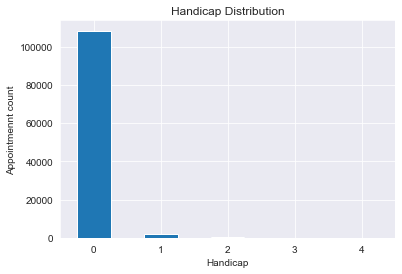

In [406]:
labels = ['0','1','2','3','4']
handi = df['handicap'].value_counts()#value contents indexed according to labels
print(handi)
handi.plot(kind = 'bar')
plt.xticks(rotation=0);
plt.title("Handicap Distribution")
plt.xlabel("Handicap")
plt.ylabel("Appointmennt count");

The chart above suggests that it is reasonable to set every values of Handicap greater than 1 to 1 as this may have no effect on our analysis. This will set the handicap column to be consistent as other categorial variable with Boolean data types in the dataframe.

In [407]:
# Set values of Handicap greater than 1 to 1
df['handicap'].replace([2,3,4], [1,1,1], inplace=True)
print(df['handicap'].value_counts()) #confirm update

0    108286
1      2241
Name: handicap, dtype: int64


#### 2) Remove negative wait time values

In [408]:
#filter data to include values where appointment_day is greater than or equal to schedule_day
df = df[df['appointment_day'] >= df['schedule_day']]

# confirm there are no negative wait time..this should yield 0 value.
print('There are', len(df[df['wait_times'] < 0]), 'negative values in the wait time column')

There are 0 negative values in the wait time column


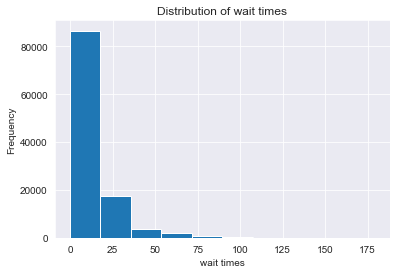

In [409]:
df['wait_times'].plot(kind='hist');
plt.title("Distribution of wait times");
plt.xlabel("wait times");

In [410]:
#create age group
#create age group
bins= [0,2,10,25,180]
labels = ['0-2','2-10','10-25','25 and over']
df['wait_timesgroup'] = pd.cut(df['wait_times'], bins=bins, labels=labels, right=False)


0-2            43776
2-10           30909
10-25          19579
25 and over    16258
Name: wait_timesgroup, dtype: int64


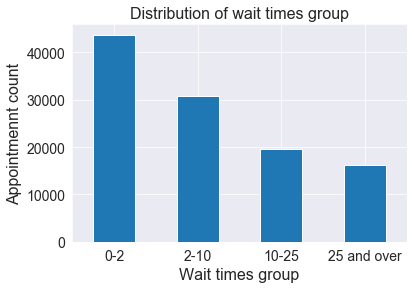

In [411]:

agegroup = df['wait_timesgroup'].value_counts()[labels] #value contents indexed according to labels
print(agegroup)
agegroup.plot(kind = 'bar')
plt.xticks(rotation=0,fontsize=14);
plt.yticks(fontsize=14)
plt.title("Distribution of wait times group",fontsize = 16)
plt.xlabel("Wait times group",fontsize = 16)
plt.ylabel("Appointmennt count", fontsize=16);

#### 3) Remove record with negative age value (s) and set maximum age to 100 (a reasonable assumption)

In [412]:
#filter data to include positive ages and a maximum patient age of 100. 

df = df[(df['age'] >= 0) & (df['age'] <= 100)]

In [413]:
#view descriptive statistics of patient's ageas to confirm change
df['age'].describe()

count    110514.000000
mean         37.084686
std          23.103024
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         100.000000
Name: age, dtype: float64

Thus our cleaned age data has a minimum of 0 and maximum of 100.

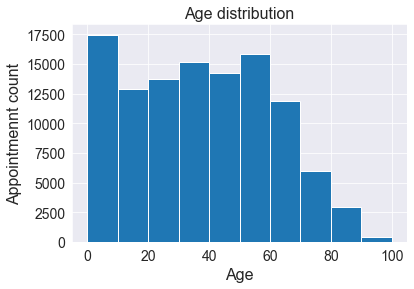

In [414]:
df['age'].plot(kind = 'hist')
plt.xticks(rotation=0,fontsize=14);
plt.yticks(fontsize= 14)
plt.title("Age distribution",fontsize=16)
plt.xlabel("Age",fontsize=16)
plt.ylabel("Appointmennt count",fontsize=16);

The age distribution histogram chart shows high frequency of two categories of age groups, 0-10 and 20-60. We will create a new column called Age groups.

#### 4) Age Group

Create a new column called age_group with different age categories


In [415]:
#create age group
bins= [0,15,25,65,100]
labels = ['0-15','15-25','25-65','65 and over']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


0-15           23256
15-25          14008
25-65          58856
65 and over    14390
Name: age_group, dtype: int64


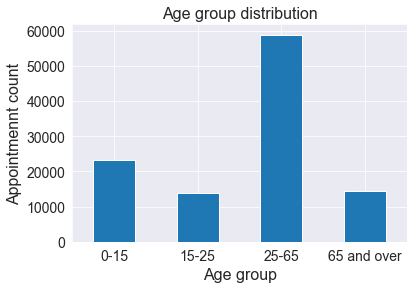

In [416]:
labels = ['0-15','15-25','25-65','65 and over']
agegroup = df['age_group'].value_counts()[labels] #value contents indexed according to labels
print(agegroup)
agegroup.plot(kind = 'bar')
plt.xticks(rotation=0,fontsize=14);
plt.yticks(fontsize=14)
plt.title("Age group distribution",fontsize=16)
plt.xlabel("Age group",fontsize=16)
plt.ylabel("Appointmennt count",fontsize=16);



### Drop columns

The next thing we would do is to drop columns that are not useful for our analysis. These include, patient_id, appointment_id, schedule_day,appointment_day and neighbourhood respectively. 

In [417]:
df.drop(columns=['patient_id','appointment_id','schedule_day','appointment_day',
                 'neighbourhood'],inplace=True);
df.head(3)

,gender,age,insurance,hypertension,diabetes,alcoholism,handicap,appointment_reminder,appointment_adherence,wait_times,day_of_week,wait_timesgroup,age_group
0,F,62,0,1,0,0,0,0,No,0,Friday,0-2,25-65
1,M,56,0,0,0,0,0,0,No,0,Friday,0-2,25-65
2,F,62,0,0,0,0,0,0,No,0,Friday,0-2,25-65


### Update column values

In [418]:
# Update values to make them more user friendly

df['appointment_adherence'].replace('No','Attended',inplace=True)
df['appointment_adherence'].replace('Yes','Missed',inplace=True)

df['gender'].replace('F',"Female",inplace=True)
df['gender'].replace('M',"Male",inplace=True)


### Rows and columns

In [419]:
print('The final data set has', df.shape[0], 'rows and', df.shape[1], 'columns respectively.')

The final data set has 110514 rows and 13 columns respectively.


# 3. Exploratory data analysis

We recall that our objective in this project is to understand or identify the reason why patients miss their appointments. For this reason, our dependent variable in the dataset is Appointment adherence with every other variable being independent.

## 3.1. Statistical analysis - Numbers

Recall that the project's aim is to predict reasons for patient's missed appointments. This implies from our data set, the dependent variable is appointment_adherence while other variables are the independent variables which we will use to predict appointment adherence.


## Question: What is the proportion of missed/attended appointments?

### 3.1.1. Dependent variable: appointment_adherence

The proportion of attended appointment is 79.812 
and the proportion of missed appointment is 20.188


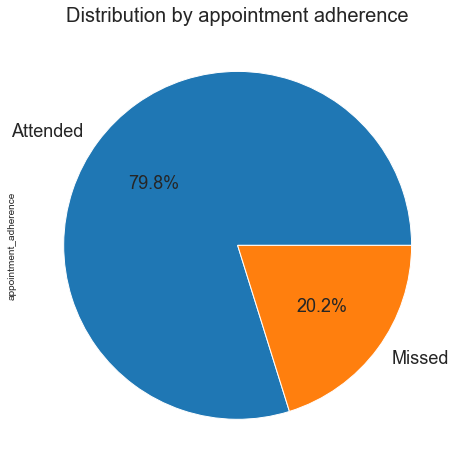

In [420]:
y_prop = df['appointment_adherence'].value_counts()[0]/df.shape[0]

print('The proportion of attended appointment is', round(y_prop*100,3), 
      '\nand the proportion of missed appointment is', round((1 - y_prop)*100,3))
plot_prop = df['appointment_adherence'].value_counts().plot.pie(figsize=(8,8),fontsize = 18,autopct='%1.1f%%');
plot_prop.set_title('Distribution by appointment adherence', fontsize = 20);

As we can see 79.8% of patients attended their appointment and 20.2% missed their appointment. With the obvious distinction in the two values, it is possible to conclude without further predictions that most booked appointments were attended. However we need to answer certain questions that would assist is in arriving out our conclusion.

## Given the total counts of appointments, how many of these appointments: 

- belong to patients with/without medical conditions?
- were for patients with/without insurance?
- were for patients who recieved/didn't recieve appointment reminder

### 3.1.2.  Independent variables

The independent variables are those variables that will be used to describe the characteristics of patient's appointment adherence. They include

- Patient's condition such as alcoholism, hypertension, diabetes and handicap; 
- Patient's information such as Gender and Age
- Other factors such as insurance, appointment reminder, wait time, and day of week respectively.

In [421]:
#Define a function that calculates each column values. 
def counts(x):
    val_count = df.groupby(x)[x].count()
    row_count = df.shape[0]
    z = round((val_count/row_count)*100,2)
    print('No'+ x,':', z[0])
    print(x, ':', z[1])

#### Categorical variables

In [422]:
counts('hypertension')
print('\n')
counts('diabetes')
print('\n')
counts('alcoholism')
print('\n')
counts('handicap')
print('\n')
counts('insurance')
print('\n')
counts('appointment_reminder')

Nohypertension : 80.27
hypertension : 19.73


Nodiabetes : 92.81
diabetes : 7.19


Noalcoholism : 96.96
alcoholism : 3.04


Nohandicap : 97.98
handicap : 2.02


Noinsurance : 90.17
insurance : 9.83


Noappointment_reminder : 67.89
appointment_reminder : 32.11


We see from the data that

- 19.73% and 80.27% of appointments were for hypertensive and non hypertensive patients respectively.

- 3.04% and 96.96% of appointments were for alcoholic and non alcoholic patients respectively.

- 7.19% and 92.81% of appointments were for diabetic and non diabetic patients respectively.

- 2.02% and 97.98% of appointments were for handicapped and non handicapped patients respectively.

- 9.83% and 90.17% of appointments were for patients without and with insurance respectively.

- 32.11% and 67.89% of appointments were for patients who did not receive and who received appointment reminder respectively.

In summary, we have more patients without medical conditions who booked an appointment. Similarly, more patients recieved an appointment reminder ad had medical insurance.

#### Gender

In [423]:
round(df.groupby('gender')['gender'].count()/ df.shape[0] * 100,2 )

gender
Female    65.0
Male      35.0
Name: gender, dtype: float64

Females had the highest counts of booked appointment, about 30% more that the males.

#### Age group

In [424]:
round(df.groupby('age_group')['age_group'].count()/ df.shape[0] * 100,2 )

age_group
0-15           21.04
15-25          12.68
25-65          53.26
65 and over    13.02
Name: age_group, dtype: float64

Highest number of appointments were booked by Adults (age group (25-65]), followed by childen (age group (0-15]). The youths (15-25] had the least count of booked appointments 

#### Day of week

In [425]:
label_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
dow_count = round(df.groupby('day_of_week')['day_of_week'].count()[label_dow]/ df.shape[0] * 100,2 )
dow_count

day_of_week
Monday       20.89
Tuesday      23.68
Wednesday    21.95
Thursday     16.35
Friday       17.11
Saturday      0.02
Name: day_of_week, dtype: float64

Most appointments were booked on weekdays with Tuesday having the highest count. We see no appointment was booked on Sunday and the minimum was booked on Saturday.

#### Wait times group

In [426]:
wtg_count = round(df.groupby('wait_timesgroup')['day_of_week'].count()/ df.shape[0] * 100,2 )
wtg_count

wait_timesgroup
0-2            39.61
2-10           27.97
10-25          17.72
25 and over    14.71
Name: day_of_week, dtype: float64

Most appointments had approximately less than or equal to 1 day wait time. The least wait times is approximately 2 weeks and over.

## What is the relationship between the dependent variable and independent variables? 

Although this question is broad, it covers a range of questions which we will present below and answer accordingly

#### Filter data sets for missed and attended appointment

In [427]:
# filter datasets for rows following missed appointment
missed = df.query('appointment_adherence == "Missed"')

#select every column in the created dataset except appointment_adherence
missed = missed.iloc[:, np.r_[0:8, 9:13]]
missed.head(2)

# filter datasets for rows following attended appointment
attended = df.query('appointment_adherence == "Attended"')

#select every column in the new dataset except appointment_adherence
attended = attended.iloc[:, np.r_[0:8, 9:13]]


#### Define a function that computes proportions ofmissed and attended appointment for columns with boolean variable (0,1)

In [428]:
def boolean_variable(dataset,x,y):
    c_totals = dataset.groupby(x)[x].count()
    m_counts = dataset.groupby([x,y])[x].count()
    prop_0 = m_counts[0] / c_totals[0]
    prop_1 = m_counts[1] / c_totals[1]
    print(x+':',prop_1)
    print('\n\nno', x+':',prop_0)

### Patient's medical condition

What proportion of patients who missed an appointment had previous medical condition?

#### 1) Hypertension

In [429]:
boolean_variable(df,'hypertension','appointment_adherence')

hypertension: appointment_adherence
Attended    0.826972
Missed      0.173028
Name: hypertension, dtype: float64


no hypertension: appointment_adherence
Attended    0.791025
Missed      0.208975
Name: hypertension, dtype: float64


#### 2) Diabetes

In [430]:
boolean_variable(df,'diabetes','appointment_adherence')

diabetes: appointment_adherence
Attended    0.819967
Missed      0.180033
Name: diabetes, dtype: float64


no diabetes: appointment_adherence
Attended    0.796424
Missed      0.203576
Name: diabetes, dtype: float64


#### 3) Alcoholism

In [431]:
boolean_variable(df,'alcoholism','appointment_adherence')

alcoholism: appointment_adherence
Attended    0.798512
Missed      0.201488
Name: alcoholism, dtype: float64


no alcoholism: appointment_adherence
Attended    0.798104
Missed      0.201896
Name: alcoholism, dtype: float64


#### 4) Handicap

In [432]:
boolean_variable(df,'handicap','appointment_adherence')

handicap: appointment_adherence
Attended    0.820134
Missed      0.179866
Name: handicap, dtype: float64


no handicap: appointment_adherence
Attended    0.797662
Missed      0.202338
Name: handicap, dtype: float64


#### Summary

Although we have observed that the highest count of appointments were booked by patients without previous medical condition such as hypertension, diabetes, alcoholism and handicappness, however the result from this dataset shows that:

- Appointments were attended most by patients with medical condition and missed by patients without medical condition, with hypertension having the highest counts for missed and attended ratio. 

- We also notice that Alcoholism don't seem to affect whether a patient would miss or attend an appointment as there's an equal probability for each.

This observation suggest that other factors are likely to be the reason for missed appointments



#### Plot the patient's condition missed appointment proportion on a bar chart

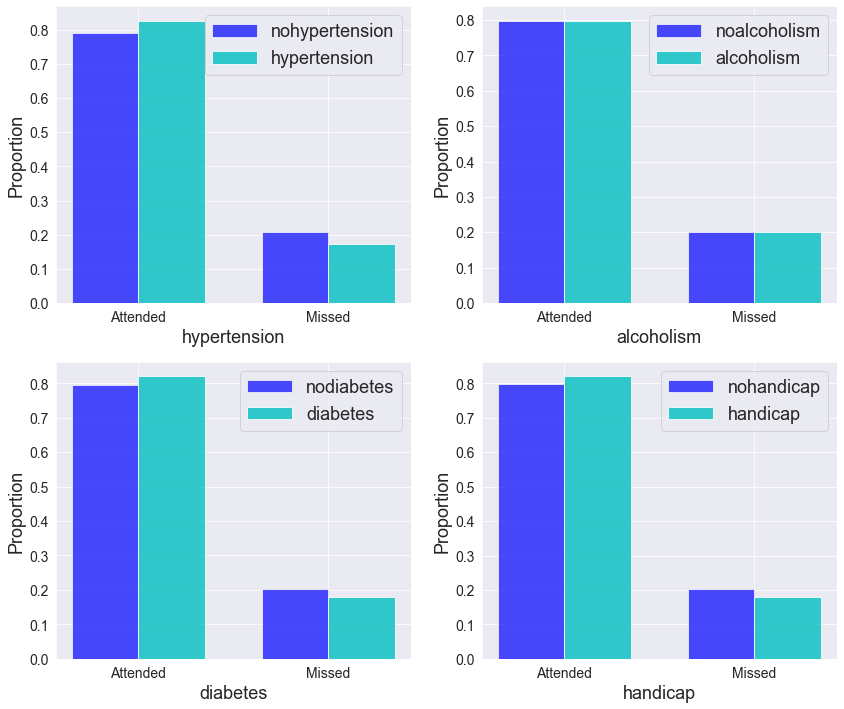

In [433]:

patient_condition = ['hypertension','alcoholism','diabetes','handicap'] #list of medical conditions
legends_ = {'legend.fontsize': 18,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(14, 12))

for i, cond in enumerate(patient_condition):
    ax = fig.add_subplot(2, 2, i+1)
    c_counts = df.groupby([cond, 'appointment_adherence'])[cond].count()
    c_totals = df.groupby(cond)[cond].count()
    plotdata1 = (c_counts[0] / c_totals[0])
    plotdata2 = (c_counts[1] / c_totals[1])
    ind = np.arange(len(plotdata1))  # the x locations for the groups
    width = 0.35       # the width of the bars
    proportion_0 = plt.bar(ind, plotdata1, width, color='b', alpha=.7, label='no'+cond)
    proportion_1 = plt.bar(ind + width, plotdata2, width, color='c', alpha=.8, label= cond)
    locations = ind + width / 2  # xtick locations
    labels = ['Attended', 'Missed']  # xtick labels
    plt.xticks(locations, labels,fontsize=18,rotation=30)
    plt.xticks(rotation=0,fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(cond,fontsize=18)
    plt.ylabel('Proportion',fontsize = 18)
    plt.legend()
   

The barchat above shows the proportion by each patient's medical condition and appointment adherence. Again we notice that alcoholism is the only condition that does not affect whether a person would miss or attend an appointment, as patients are likely to miss and attend appointments with equal probability

### Patient's information

#### 1) Age group

What age group of patients are most likely to miss an appointment?

In [434]:
def agegroup_variable(dataset,x,y):
    c_totals = dataset.groupby(x)[x].count()
    m_counts = dataset.groupby([x,y])[x].count()
    prop_15 = m_counts['0-15'] / c_totals['0-15']
    prop_25 = m_counts['15-25'] / c_totals['15-25']
    prop_65 = m_counts['25-65'] / c_totals['25-65']
    prop_over = m_counts['65 and over'] / c_totals['65 and over']
    print('(0-15]:',prop_15)
    print('\n\n(15-25]:',prop_25)
    print('\n\n(25-65]:',prop_65)
    print('\n\n65 and over:',prop_over)

In [435]:
agegroup_variable(df,'age_group','appointment_adherence')

(0-15]: appointment_adherence
Attended    0.788227
Missed      0.211773
Name: age_group, dtype: float64


(15-25]: appointment_adherence
Attended    0.74743
Missed      0.25257
Name: age_group, dtype: float64


(25-65]: appointment_adherence
Attended    0.802586
Missed      0.197414
Name: age_group, dtype: float64


65 and over: appointment_adherence
Attended    0.845101
Missed      0.154899
Name: age_group, dtype: float64


The least counts of appointment were from seniors (age group 65 and over), however we see from this data set that the age group have the highest attendance rate. The highest count of missed appointments belong to youths then children. 

#### Plot the age group proportion on a bar chat

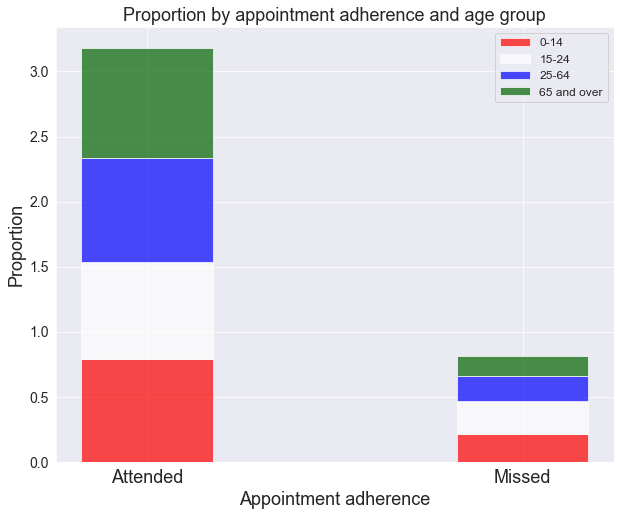

In [436]:
legends_ = {'legend.fontsize': 12,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(10, 8))

c_counts = df.groupby(['age_group', 'appointment_adherence'])['age_group'].count()
c_totals = df.groupby('age_group')['age_group'].count()
plotdata1 = (c_counts['0-15'] / c_totals['0-15'])
plotdata2 = (c_counts['15-25'] / c_totals['15-25'])
plotdata3 = (c_counts['25-65'] / c_totals['25-65'])
plotdata4 = (c_counts['65 and over'] / c_totals['65 and over'])
ind = np.arange(len(plotdata1))  # the x locations for the groups
width = 0.35       # the width of the bars
proportion_0 = plt.bar(ind, plotdata1, width, color='r', alpha=.7, label='0-14')
proportion_1 = plt.bar(ind, plotdata2, width, color='white', alpha=.7, label= '15-24',bottom = plotdata1)
proportion_2 = plt.bar(ind, plotdata3, width, color='blue', alpha=.7, label='25-64',bottom=plotdata2+plotdata1)
proportion_3 = plt.bar(ind, plotdata4, width, color='darkgreen', alpha=.7, label= '65 and over',bottom=plotdata3+plotdata2+plotdata1)
locations = ind  # xtick locations
labels = ['Attended', 'Missed']  # xtick labels
plt.xticks(locations, labels,fontsize=18,rotation=0)
plt.yticks(fontsize=14)
plt.title('Proportion by appointment adherence and age group',fontsize=18)
plt.xlabel('Appointment adherence',fontsize=18)
plt.ylabel('Proportion',fontsize = 18)
plt.legend();
   

The data visualization and numerics shows that youths (agegroup 15-24) are most likely to miss their appointments and least likely to attend their appointments while adults (age group 65 and over) are most likely to attend their apointment and least likely to miss their appointment.

### 2) Gender

#### Is gender a determining factor whether a patient would attend or miss an appointment? 



In [437]:
def gender_variable(dataset,x,y):
    c_totals = dataset.groupby(x)[x].count()
    m_counts = dataset.groupby([x,y])[x].count()
    prop_F = m_counts['Female'] / c_totals['Female']
    prop_M = m_counts['Male'] / c_totals['Male']
    print('Female:',prop_F)
    print('\n\nMale:',prop_M)

In [438]:
gender_variable(df,'gender','appointment_adherence')

Female: appointment_adherence
Attended    0.796907
Missed      0.203093
Name: gender, dtype: float64


Male: appointment_adherence
Attended    0.800362
Missed      0.199638
Name: gender, dtype: float64


#### Plot the gender proportion on a bar chat

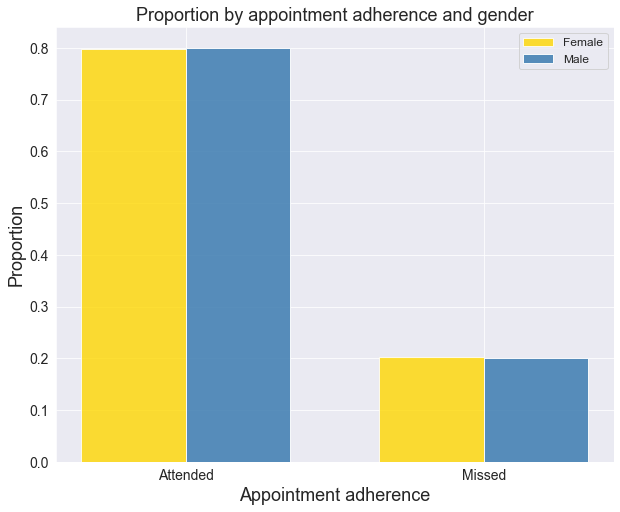

In [439]:
legends_ = {'legend.fontsize': 12,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(10, 8))

c_counts = df.groupby(['gender', 'appointment_adherence'])['age_group'].count()
c_totals = df.groupby('gender')['age_group'].count()
plotdata1 = (c_counts['Female'] / c_totals['Female'])
plotdata2 = (c_counts['Male'] / c_totals['Male'])
ind = np.arange(len(plotdata1))  # the x locations for the groups
width = 0.35       # the width of the bars
proportion_0 = plt.bar(ind, plotdata1, width, color='gold', alpha=.8, label='Female')
proportion_1 = plt.bar(ind+width, plotdata2, width, color='steelblue', alpha=.9, label= 'Male')
locations = ind + width / 2 # xtick locations
labels = ['Attended', 'Missed']  # xtick labels
plt.xticks(locations, labels,fontsize=14,rotation=0)
plt.yticks(fontsize=14)
plt.title('Proportion by appointment adherence and gender',fontsize=18)
plt.xlabel('Appointment adherence',fontsize=18)
plt.ylabel('Proportion',fontsize = 18)
plt.legend();
   

 As shown, gender does not seem to affect a patient's adherence to an appointment as both males and females miss up to approximately 20% of their appointments and attended up to approximately 80%

### Medical insurance and appointment reminder

#### 1) Medical insurance

#### Are patients with medical insurance most likely to miss an appointment?

In [440]:
boolean_variable(df,'insurance','appointment_adherence')

insurance: appointment_adherence
Attended    0.762637
Missed      0.237363
Name: insurance, dtype: float64


no insurance: appointment_adherence
Attended    0.801983
Missed      0.198017
Name: insurance, dtype: float64


#### 2) Appointment reminder
#### Does appointment reminder notification help to reduce the proportion of missed appointment?

In [441]:
boolean_variable(df,'appointment_reminder','appointment_adherence')

appointment_reminder: appointment_adherence
Attended    0.724247
Missed      0.275753
Name: appointment_reminder, dtype: float64


no appointment_reminder: appointment_adherence
Attended    0.833047
Missed      0.166953
Name: appointment_reminder, dtype: float64


We have observed that highest count of appointments were for patients without insurance and who didn't receive appointment reminder (notification). From the data set above, we see that these patients had the highest attendance rate while highest missed appointment rate belongs to groups with insurance and recieved an appointment notification.

#### Plot the appointment reminder and insurance proportions on a barchat

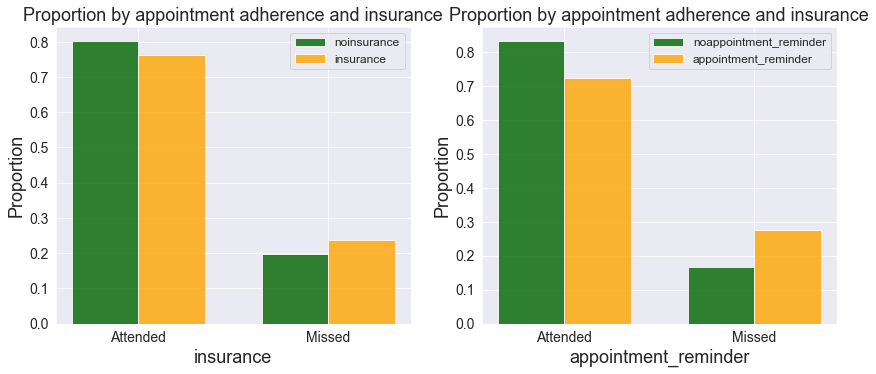

In [442]:
#list of patient's information
others = ['insurance','appointment_reminder'] 
legends_ = {'legend.fontsize': 12,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(14, 12))

for i, cond in enumerate(others):
    ax = fig.add_subplot(2, 2, i+1)
    c_counts = df.groupby([cond, 'appointment_adherence'])[cond].count()
    c_totals = df.groupby(cond)[cond].count()
    plotdata1 = (c_counts[0] / c_totals[0])
    plotdata2 = (c_counts[1] / c_totals[1])
    ind = np.arange(len(plotdata1))  # the x locations for the groups
    width = 0.35       # the width of the bars
    proportion_0 = plt.bar(ind, plotdata1, width, color='darkgreen', alpha=.8, label='no'+cond)
    proportion_1 = plt.bar(ind + width, plotdata2, width, color='orange', alpha=.8, label= cond)
    locations = ind + width / 2  # xtick locations
    plt.title('Proportion by appointment adherence and insurance',fontsize=18)
    labels = ['Attended', 'Missed']  # xtick labels
    plt.xticks(locations, labels,fontsize=14,rotation=0)
    plt.yticks(fontsize=14)
    plt.xlabel(cond,fontsize=18)
    plt.ylabel('Proportion',fontsize = 18)
    plt.legend()
   

- Surprisingly, those with insurance and who recieved an appointment reminder are seen to most likely miss their appointments compared to those without insurance and appointment reminder notification.
-  It is possible that not all patients signed up to recieve reminder notification so this could be a limitation to collected data.

### Appointment day of week

#### What day of week are patients most likely to miss a scheduled appointment?

In [443]:
def dow_variable(dataset,x,y):
    c_totals = dataset.groupby(x)[x].count()
    m_counts = dataset.groupby([x,y])[x].count()
    prop_Mo = m_counts['Monday'] / c_totals['Monday']
    prop_Tu = m_counts['Tuesday'] / c_totals['Tuesday']
    prop_We = m_counts['Wednesday'] / c_totals['Wednesday']
    prop_Th = m_counts['Thursday'] / c_totals['Thursday']
    prop_Fr = m_counts['Friday'] / c_totals['Friday']
    prop_Sa = m_counts['Saturday'] / c_totals['Saturday']

    print('Monday:', round(prop_Mo,6))
    print('\n\nTuesday', round(prop_Tu,6))
    print('\n\nWednesday', round(prop_We,6))
    print('\n\nThursday', round(prop_Th,6))
    print('\n\nFriday', round(prop_Fr,6))
    print('\n\nSaturday', round(prop_Sa,6))


In [444]:
dow_variable(df,'day_of_week','appointment_adherence')

Monday: appointment_adherence
Attended    0.802478
Missed      0.197522
Name: day_of_week, dtype: float64


Tuesday appointment_adherence
Attended    0.797822
Missed      0.202178
Name: day_of_week, dtype: float64


Wednesday appointment_adherence
Attended    0.799002
Missed      0.200998
Name: day_of_week, dtype: float64


Thursday appointment_adherence
Attended    0.795307
Missed      0.204693
Name: day_of_week, dtype: float64


Friday appointment_adherence
Attended    0.794544
Missed      0.205456
Name: day_of_week, dtype: float64


Saturday appointment_adherence
Attended    0.958333
Missed      0.041667
Name: day_of_week, dtype: float64


#### Plot the day of week proportion on a bar chart

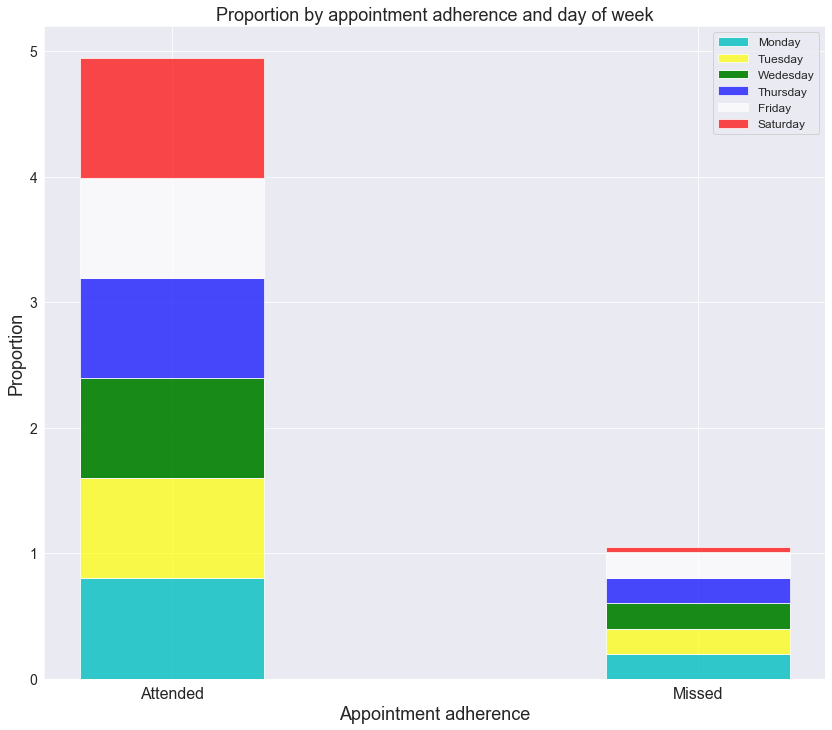

In [445]:
legends_ = {'legend.fontsize': 12,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(14, 12))

c_counts = df.groupby(['day_of_week', 'appointment_adherence'])['day_of_week'].count()
c_totals = df.groupby('day_of_week')['day_of_week'].count()
plotdata1 = (c_counts['Monday'] / c_totals['Monday'])
plotdata2 = (c_counts['Tuesday'] / c_totals['Tuesday'])
plotdata3 = (c_counts['Wednesday'] / c_totals['Wednesday'])
plotdata4 = (c_counts['Thursday'] / c_totals['Thursday'])
plotdata5 = (c_counts['Friday'] / c_totals['Friday'])
plotdata6 = (c_counts['Saturday'] / c_totals['Saturday'])
ind = np.arange(len(plotdata1))  # the x locations for the groups
width = 0.35       # the width of the bars
proportion_0 = plt.bar(ind, plotdata1, width, color='c', alpha=.8, label='Monday')
proportion_1 = plt.bar(ind, plotdata2, width, color='yellow', alpha=.7, label= 'Tuesday',bottom = plotdata1)
proportion_2 = plt.bar(ind, plotdata3, width, color='green', alpha=.9, label='Wedesday',bottom=plotdata2+plotdata1)
proportion_3 = plt.bar(ind, plotdata4, width, color='blue', alpha=.7, label= 'Thursday',bottom=plotdata3+plotdata2+plotdata1)
proportion_4 = plt.bar(ind, plotdata5, width, color='white', alpha=.7, label= 'Friday',bottom = plotdata4+plotdata3+plotdata2+plotdata1)
proportion_5 = plt.bar(ind, plotdata6, width, color='r', alpha=.7, label='Saturday',bottom=plotdata5+plotdata4+plotdata3+plotdata2+plotdata1)

locations = ind  # xtick locations
labels = ['Attended', 'Missed']  # xtick labels
plt.xticks(locations, labels,fontsize=16,rotation=0)
plt.yticks(fontsize=14)
plt.title('Proportion by appointment adherence and day of week',fontsize=18)
plt.xlabel('Appointment adherence',fontsize=18)
plt.ylabel('Proportion',fontsize = 18)
plt.legend();
   

The data for appointment day of week shows that apointments booked on Fridays are most likely to be missed followed by Thursdays. This makes sense as we have seen that the age group of patients who miss their appointment most are youths as they usually prefer to travel for weekends on Fridays.

### Wait times

#### How many days interval between schedule day and appointment day should an appointment be scehduled to optimize patient's likelyhood of attending appointment? 

Proportion by missed appointment

In [446]:
def wait_timesgroup_variable(dataset,x,y):
    c_totals = dataset.groupby(x)[x].count()
    m_counts = dataset.groupby([x,y])[x].count()
    prop_2 = m_counts['0-2'] / c_totals['0-2']
    prop_10 = m_counts['2-10'] / c_totals['2-10']
    prop_25 = m_counts['10-25'] / c_totals['10-25']
    prop_over25 = m_counts['25 and over'] / c_totals['25 and over']
    
    print('(0-2] days:', round(prop_2,6))
    print('\n\n(2-10] days:)', round(prop_10,6))
    print('\n\n(10-25] days:)', round(prop_25,6))
    print('\n\n 25 days and over', round(prop_over25,6))
    

In [447]:
wait_timesgroup_variable(df,'wait_timesgroup','appointment_adherence')

(0-2] days: appointment_adherence
Attended    0.933635
Missed      0.066365
Name: wait_timesgroup, dtype: float64


(2-10] days:) appointment_adherence
Attended    0.74869
Missed      0.25131
Name: wait_timesgroup, dtype: float64


(10-25] days:) appointment_adherence
Attended    0.676678
Missed      0.323322
Name: wait_timesgroup, dtype: float64


 25 days and over appointment_adherence
Attended    0.673433
Missed      0.326567
Name: wait_timesgroup, dtype: float64


The highest counts of appointment had wait time of 1 day or less and obviously we have seen from the dataset that this wait time has the highest attendance rate with corresponding lower miss appointment rate. Thus it is recommended that appointment wait times should be short enough for better attendace rate.

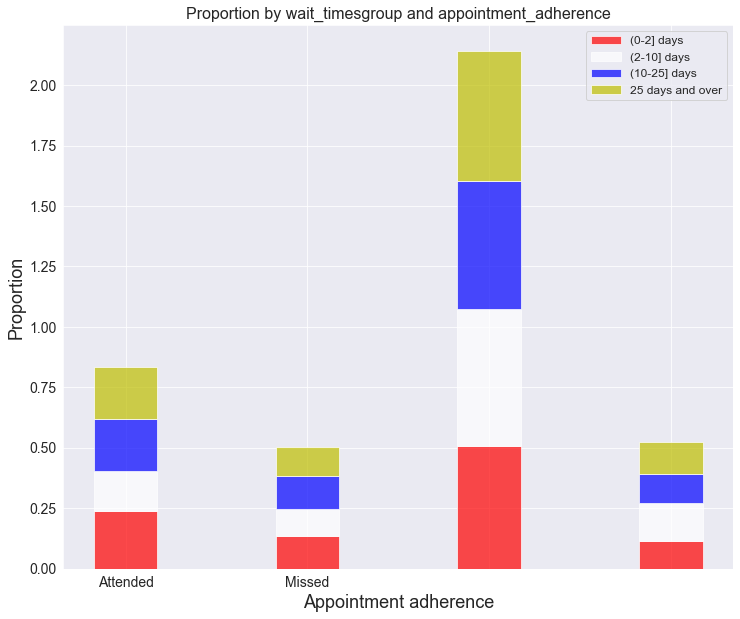

In [448]:
legends_ = {'legend.fontsize': 12,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(12, 10))

c_totals = df.groupby('wait_timesgroup')['wait_timesgroup'].count()
m_counts = df.groupby(['wait_timesgroup','age_group'])['wait_timesgroup'].count()
prop_2 = m_counts['0-2'] / c_totals['0-2']
prop_10 = m_counts['2-10'] / c_totals['2-10']
prop_25 = m_counts['10-25'] / c_totals['10-25']
prop_over25 = m_counts['25 and over'] / c_totals['25 and over']

ind_w = np.arange(len(prop_2))  # the x locations for the groups
width = 0.35       # the width of the bars

# plot bars
a1_bars = plt.bar(ind_w, prop_2, width, color='r', alpha=.7, label='(0-2] days')
b1_bars = plt.bar(ind_w, prop_10, width, color='w', alpha=.7, label='(2-10] days',bottom = prop_2)
c1_bars = plt.bar(ind_w,prop_25, width, color='b', alpha=.7, label='(10-25] days',bottom = prop_10+prop_2)
d1_bars = plt.bar(ind_w, prop_over25, width, color='y', alpha=.7, label='25 days and over',bottom =prop_25+prop_10+prop_2 )


# title and labels
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Proportion',fontsize=18)
plt.xlabel('Appointment adherence',fontsize=18)
plt.title('Proportion by wait_timesgroup and appointment_adherence',fontsize=16)
locations = ind_w  # xtick locations
labels = ['Attended','Missed'] # xtick labels
plt.xticks(locations, labels)

# legend
plt.legend();
   

The data shows that for a wait time of 1 day or less, patient's are more likely to attend their appointment, followed by a wait time of 1 week or less. For a wait time of more than 2 weeks are less likely to attend their appointment. This result is not surprising as most patient's are likely to feel better or tend to forget an appointment scheduled far ahead of time.

### Summary

The research question 2 is a generalization of so many subset of questions such as 

- Is gender a determining factor whether a patient would attend or miss an appointment? 

- How many days interval between schedule day and appointment day should an appointment be scehduled to optimize patient's likelyhood of attending appointment? 

- Out of the four medical conditions listed in the dataset, which condition are patients who miss their appointment most likely to have?

- What day of week are patients most likely to miss a scheduled appointment?

- What age group of patients are most likely to miss an appointment?

- Does appointment reminder notification help to reduce the proportion of missed appointment?

- Are patients with medical insurance most likely to miss an appointment?

### Result

- Our analysis and data sets show that alcoholism and gender are not determining factors whether a patient would miss or attend an appointment.
- Youths then followed by children are most likely to miss an appointment however adults had the highest count of booked appointments.
- Appointments booked on Fridays and Thursdays are mostlikely to be missed, however the highest count of appointments was Tuesday.
- A shorter wait time results in increased attendance rate.

### Further investigation (focus)

We have observed that youths then children are most likely to miss an appointment, can we identify the reasons behind this proportion? Could it be health status, like hypertension, diabetes, or handicap? lack of appointment reminder notification? Or unfavourable appointment day of week?  We will look into some of these factors.

## What is the reason why certain age group miss an appointment? 

To answer this question, we will focus on the independent variables that we have seen mostly affects miss appointment. These include hypertension, diabetes, wait times and day of week respectively.

#### Proportion of patient's conditions and age group for missed appointments.

In [449]:
#call the boolean_variable function earlier defined, for a missed appointment dataset
boolean_variable(missed,'hypertension','age_group') 

hypertension: age_group
0-15           0.002121
15-25          0.005832
25-65          0.628844
65 and over    0.363203
Name: hypertension, dtype: float64


no hypertension: age_group
0-15           0.265225
15-25          0.189654
25-65          0.498786
65 and over    0.046335
Name: hypertension, dtype: float64


In [450]:
boolean_variable(missed,'diabetes','age_group')

diabetes: age_group
0-15           0.003497
15-25          0.016084
25-65          0.576923
65 and over    0.403497
Name: diabetes, dtype: float64


no diabetes: age_group
0-15           0.235621
15-25          0.168335
25-65          0.516929
65 and over    0.079115
Name: diabetes, dtype: float64


In [451]:
boolean_variable(missed,'alcoholism','age_group')

alcoholism: age_group
0-15           0.011817
15-25          0.036928
25-65          0.865583
65 and over    0.085672
Name: alcoholism, dtype: float64


no alcoholism: age_group
0-15           0.227281
15-25          0.162383
25-65          0.509984
65 and over    0.100351
Name: alcoholism, dtype: float64


In [452]:
boolean_variable(missed,'handicap','age_group')

handicap: age_group
0-15           0.141791
15-25          0.084577
25-65          0.497512
65 and over    0.276119
Name: handicap, dtype: float64


no handicap: age_group
0-15           0.222192
15-25          0.159934
25-65          0.521201
65 and over    0.096673
Name: handicap, dtype: float64


### Summary

We see that youths (15-25) and children (0-15) who miss their appointments the most compared to other age groups were most likely non hypertensive, alcoholic and diabetic. However Adults (25-65) with the highest count of booked appointments (compared to other  age groups) and who missed their appointments were most likely hypertensive, diabetic and alcoholic. 

Again the youths and children's proportion for a missed appointment shows that they were not handicapped. This is equally true for age group 25-65. However the age group 65 and over who missed appointment were likely more handicapped. 

Notice that we included alcoholism in our analysis here despite knowing that it doesnt affect the appointment adherence. This is because we wanted to look at this scenario when considering a given sample of population.

#### Plot proportions of patient's condition on bar chat

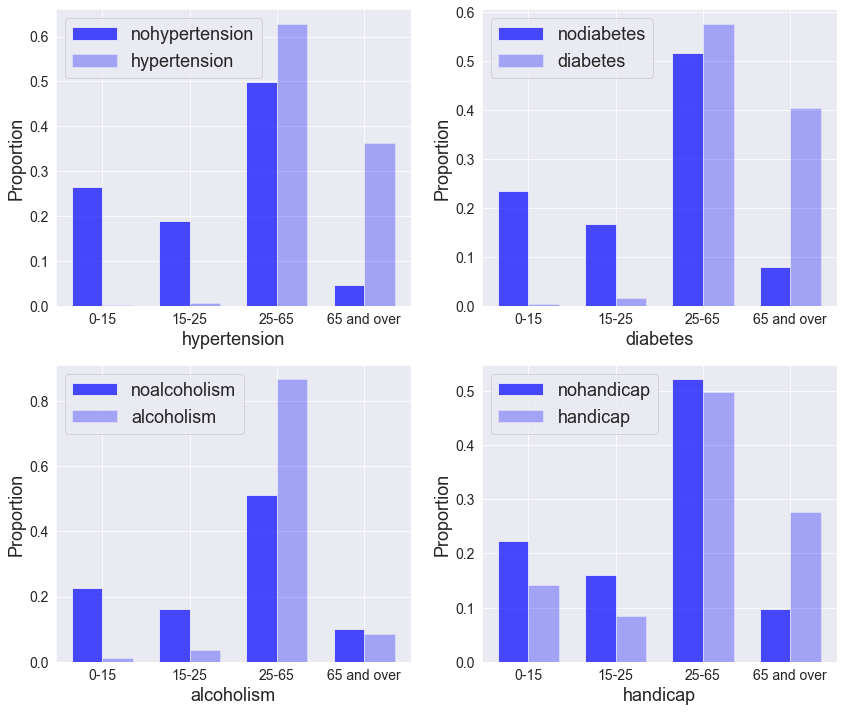

In [453]:
#list of medical conditions
patient_condition = ['hypertension','diabetes','alcoholism','handicap'] 
legends_ = {'legend.fontsize': 18,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(14, 12))

for i, cond in enumerate(patient_condition):
    ax = fig.add_subplot(2, 2, i+1)
    em_counts = missed.groupby([cond, 'age_group'])[cond].count()
    em_totals = missed.groupby(cond)[cond].count()
    plot_em1 = (em_counts[0] / em_totals[0])
    plot_em2 = (em_counts[1] / em_totals[1])
    ind = np.arange(len(plot_em1))  # the x locations for the groups
    width = 0.35       # the width of the bars
    missed_prop0 = plt.bar(ind, plot_em1, width, color='blue', alpha=.7, label= 'no' + cond)
    missed_prop1 = plt.bar(ind + width, plot_em2, width, color='blue', alpha=.3, label= cond)
    locations = ind + width / 2  # xtick locations
    labels = ['0-15','15-25','25-65','65 and over']  # xtick labels
    plt.xticks(locations, labels,fontsize=18,rotation=30)
    plt.xticks(rotation=0,fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(cond,fontsize=18)
    plt.ylabel('Proportion',fontsize = 18)
    plt.legend()

### Insurance and appointment reminder

#### 1) Insurance

In [454]:
boolean_variable(missed,'insurance','age_group')

insurance: age_group
0-15           0.216059
15-25          0.185803
25-65          0.583398
65 and over    0.014740
Name: insurance, dtype: float64


no insurance: age_group
0-15           0.221355
15-25          0.155020
25-65          0.512593
65 and over    0.111032
Name: insurance, dtype: float64


#### 2) Appointment_reminder

In [455]:
boolean_variable(missed,'appointment_reminder','age_group')

appointment_reminder: age_group
0-15           0.205948
15-25          0.168540
25-65          0.536795
65 and over    0.088716
Name: appointment_reminder, dtype: float64


no appointment_reminder: age_group
0-15           0.232298
15-25          0.150794
25-65          0.508262
65 and over    0.108645
Name: appointment_reminder, dtype: float64


### Summary

Although we have seen that the highest proportion of missed appointments (in general) were for patients with insurance and those who received appointment reminder notification,
however when we consider a subset of patients by age group, 

- we see that youths and adults who missed their appointments did not likely have insurance unlike children and seniors who did. This could be attributed to benefits given to children and seniors by the government. It is recommended that strategies to provide insurance for the youths and adults shouldbe provided to minimize missed appointment rate.

- This is in contrast with appointment reminder notification, here we see that youths and adults who missed their appointments likely had received appointment reminder notification unlike children and seniors who didn't receive an appointment reminder. It is possible that parents of the children did not sign them up for an appointment notification alert or theseniors whom we haveseen were mostly handicapped, could not sign themselves up for the notification. It is recommended 

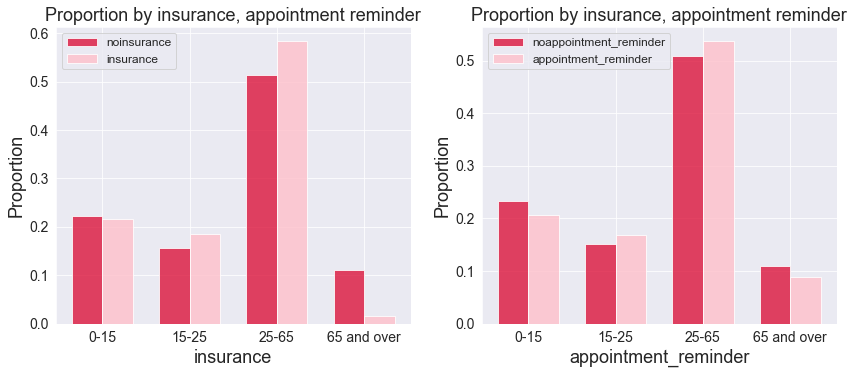

In [456]:
#list of patient's information
others = ['insurance','appointment_reminder'] 
legends_ = {'legend.fontsize': 12,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(14, 12))

for i, cond in enumerate(others):
    ax = fig.add_subplot(2, 2, i+1)
    c_counts = missed.groupby([cond, 'age_group'])[cond].count()
    c_totals = missed.groupby(cond)[cond].count()
    plotdata1 = (c_counts[0] / c_totals[0])
    plotdata2 = (c_counts[1] / c_totals[1])
    ind = np.arange(len(plotdata1))  # the x locations for the groups
    width = 0.35       # the width of the bars
    proportion_0 = plt.bar(ind, plotdata1, width, color='crimson', alpha=.8, label= 'no'+cond)
    proportion_1 = plt.bar(ind + width, plotdata2, width, color='pink', alpha=.8, label= cond)
    locations = ind + width / 2  # xtick locations
    plt.title('Proportion by insurance, appointment reminder',fontsize=18)
    labels = labels = ['0-15','15-25','25-65','65 and over']  # xtick labels
    plt.xticks(locations, labels,fontsize=14,rotation=0)
    plt.yticks(fontsize=14)
    plt.xlabel(cond,fontsize=18)
    plt.ylabel('Proportion',fontsize = 18)
    plt.legend()
   

### Wait times group

In [457]:
wait_timesgroup_variable(missed,'wait_timesgroup','age_group')

(0-2] days: age_group
0-15           0.278485
15-25          0.191394
25-65          0.443373
65 and over    0.086747
Name: wait_timesgroup, dtype: float64


(2-10] days:) age_group
0-15           0.179220
15-25          0.146517
25-65          0.553238
65 and over    0.121025
Name: wait_timesgroup, dtype: float64


(10-25] days:) age_group
0-15           0.223855
15-25          0.170300
25-65          0.516588
65 and over    0.089258
Name: wait_timesgroup, dtype: float64


 25 days and over age_group
0-15           0.246186
15-25          0.144283
25-65          0.520625
65 and over    0.088906
Name: wait_timesgroup, dtype: float64


- Youths (15-25) are more likely to miss an appointment scheduled less than or equal to a day or 2 weeks waitimes. They would attend an appointment scheduled withing over 2weeks or more. This implies that longer wait times might not necessarily be a reason for missed appointment in youths.

- We also see that children are more likely to attend an appointment schulded 2-7days and miss an appointment scheduled less than or equal to a day.

- Adults with the highest count of booked appointments are likely to attend an appointment scheduled 1 day or less.

- Seniors are likely to miss an appointment scheduled 2-10 days in advance.

#### Plot the wait times proportion on bar

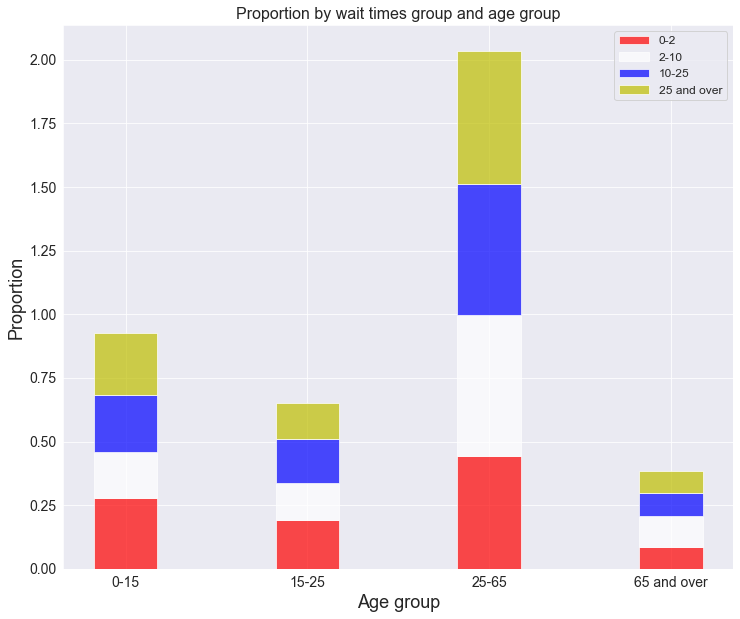

In [458]:
legends_ = {'legend.fontsize': 12,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(12, 10))

baby = missed.groupby('wait_timesgroup')['wait_timesgroup'].count()
bb = missed.groupby(['wait_timesgroup','age_group'])['wait_timesgroup'].count()
a = bb['0-2']/baby['0-2']
b = bb['2-10']/baby['2-10']
c = bb['10-25']/baby['10-25']
d = bb['25 and over']/baby['25 and over']
ind_wait = np.arange(len(a))  # the x locations for the groups
width = 0.35       # the width of the bars

# plot bars
a_bars = plt.bar(ind_wait, a, width, color='r', alpha=.7, label='0-2')
b_bars = plt.bar(ind_wait, b, width, color='w', alpha=.7, label='2-10',bottom = a)
c_bars = plt.bar(ind_wait,c, width, color='b', alpha=.7, label='10-25',bottom = b+a)
d_bars = plt.bar(ind_wait, d, width, color='y', alpha=.7, label='25 and over',bottom =c+b+a )


# title and labels
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Proportion',fontsize=18)
plt.xlabel('Age group',fontsize=18)
plt.title('Proportion by wait times group and age group',fontsize=16)
locations = ind_wait   # xtick locations
labels = ['0-15','15-25','25-65','65 and over'] # xtick labels
plt.xticks(locations, labels)

# legend
plt.legend();

In [459]:
dow_variable(missed,'day_of_week','age_group')

Monday: age_group
0-15           0.211231
15-25          0.150910
25-65          0.535205
65 and over    0.102654
Name: day_of_week, dtype: float64


Tuesday age_group
0-15           0.221928
15-25          0.165406
25-65          0.513422
65 and over    0.099244
Name: day_of_week, dtype: float64


Wednesday age_group
0-15           0.235644
15-25          0.160582
25-65          0.511280
65 and over    0.092494
Name: day_of_week, dtype: float64


Thursday age_group
0-15           0.219519
15-25          0.153014
25-65          0.526088
65 and over    0.101379
Name: day_of_week, dtype: float64


Friday age_group
0-15           0.212815
15-25          0.161091
25-65          0.520844
65 and over    0.105250
Name: day_of_week, dtype: float64


Saturday age_group
0-15           0.0
15-25          0.0
25-65          0.0
65 and over    1.0
Name: day_of_week, dtype: float64


Youths will most likely miss an appointment scheduled on Tuesdays then Fridays, while children will most miss an apointment scheduled on Wednesdays. Adults will most likely miss an appointment scheduled on Mondays. Seniors will likely miss an appointment scheduled Saturdays.

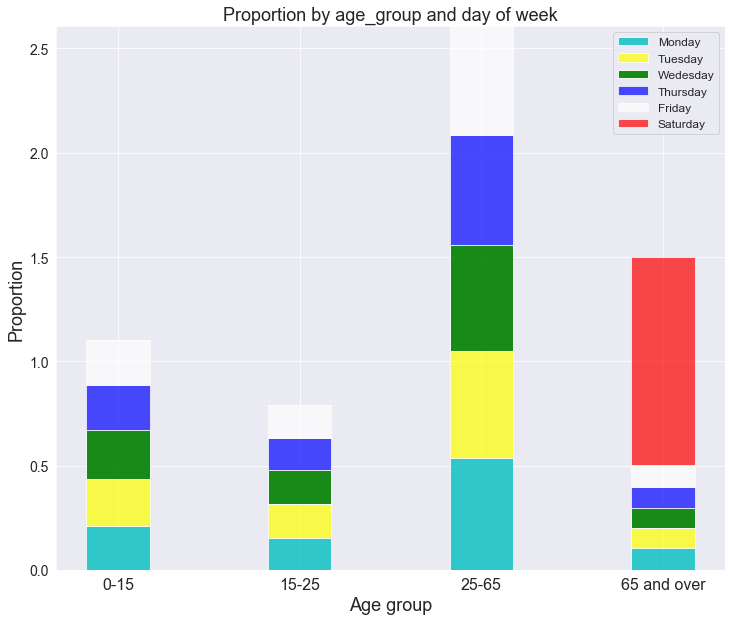

In [460]:
legends_ = {'legend.fontsize': 12,'legend.handlelength': 2.5}
plt.rcParams.update(legends_)

fig = plt.figure(figsize=(12, 10))

c_counts = missed.groupby(['day_of_week', 'age_group'])['day_of_week'].count()
c_totals = missed.groupby('day_of_week')['day_of_week'].count()
plotdata1 = (c_counts['Monday'] / c_totals['Monday'])
plotdata2 = (c_counts['Tuesday'] / c_totals['Tuesday'])
plotdata3 = (c_counts['Wednesday'] / c_totals['Wednesday'])
plotdata4 = (c_counts['Thursday'] / c_totals['Thursday'])
plotdata5 = (c_counts['Friday'] / c_totals['Friday'])
plotdata6 = (c_counts['Saturday'] / c_totals['Saturday'])
ind = np.arange(len(plotdata1))  # the x locations for the groups
width = 0.35       # the width of the bars
proportion_0 = plt.bar(ind, plotdata1, width, color='c', alpha=.8, label='Monday')
proportion_1 = plt.bar(ind, plotdata2, width, color='yellow', alpha=.7, label= 'Tuesday',bottom = plotdata1)
proportion_2 = plt.bar(ind, plotdata3, width, color='green', alpha=.9, label='Wedesday',bottom=plotdata2+plotdata1)
proportion_3 = plt.bar(ind, plotdata4, width, color='blue', alpha=.7, label= 'Thursday',bottom=plotdata3+plotdata2+plotdata1)
proportion_4 = plt.bar(ind, plotdata5, width, color='white', alpha=.7, label= 'Friday',bottom = plotdata4+plotdata3+plotdata2+plotdata1)
proportion_5 = plt.bar(ind, plotdata6, width, color='r', alpha=.7, label='Saturday',bottom=plotdata5+plotdata4+plotdata3+plotdata2+plotdata1)

locations = ind  # xtick locations
labels = ['0-15','15-25','25-65','65 and over'] # xtick labels
plt.xticks(locations, labels,fontsize=16,rotation=0)
plt.yticks(fontsize=14)
plt.title('Proportion by age_group and day of week',fontsize=18)
plt.xlabel('Age group',fontsize=18)
plt.ylabel('Proportion',fontsize = 18)
plt.legend();
   

# Limitations

- Our analysis focused on the provided dataset. This could be a limitationin the sense that certain information such as patient's physical activities (such as sports) were not provided as this maybe reason why most youths were seen to miss their appointments more other than insurance. 

- There are a few inconsistences on the dataset such as negative age values and weird scheduling dates, that we had to clean up during the data wrangling process. Since we had to remove such data entries, in realitity, this could have an effect on the complete data analysis model. It is recommended that proper data entery records should be done to avoid losses.

- Finally we have only provided a statistical analysis of the data, thus it is improper to draw conclusions why patients miss anappointment, as models such as machine learning and inferential statistics were not employed in the analysis. 








# Conclusion

Calendars/reminders and parent reminders were the most commonly reported strategies to facilitate clinic attendance. Adolescents also reported the need for flexible scheduling and improved patient-provider communication.

We have explored the reasons for medical missed appointment using the data given. Our analysis shows that one can determine reasons for a missed appointment by finidng a correlation between scheduled appointments and patient's information. 

The analysis confirmed that several variables were correlated with Missed appointments. Although gender does not seem to affect appointment adherence, 

- We observed that the basic reason why youths miss an appointment is no medical insurance as most youths who missed appointments were likely with no medical conditions, they received appointment reminder notificationn and also they had long appointment wait times.

- Moreso, children are the second likely to miss an appointment and the major factor is no appointment reminder notifications and likely an appointment booked on Wednesdays. To facilitate attendance to appointment, appointment reminders and parent's reminder will be a good startegy. Moreso, flexible scheduling date would be helpful too.

- Adults who are likely to miss an appointment are seen to have medical conditions such as hypertension, diabetes and alcoholism. They also had no medical insurance coverage. Since these group of patients had the highest proportion of missed appointments, a recommendation will be for clinic facilities to pay closer attention to these patients and improve on their patient-provider communications and services.

- Seniors are less likely to miss an appointment. However those that miss appointment are seen to be hanicapped, alcoholic, hypertensive and diabetic. They are also more likely to miss appointments shceduled for Saturdays.

In summary, overall appointments scheduled Fridays may result in a missed appointment. One expects that an appointment reminder would lower the missed appointment rate, but this was contrary to what we saw in our analysis. It is possible that most patients did not sign up for an sms alert and thus not a high proportion of sms were sent out as shown in the appointment reminder distribution for the combined dataset. 

In terms of previous medical conditions of patients, we observe that appointments where patients were handicapped were more missed. Thus overal, more attention could be paid on such patients and better accessibility such as transport provided. 






In [461]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate a data set - Project2.ipynb'])

0